# Methoden-Übersicht
für das Fachpraktikum Simulation Multiagentensysteme
mit dem Thema Entwicklung eines Multiagentensystems zur kooperativen Erkundung in einer 2D-Simulationsumgebung

## Umgebungswahrnehmung

Umgebung: 2D-Moore-Grid

### Raycasting mit Bresenham-Algorithmus

Simuliert die Sichtlinie und Sensorreichweite im Grid, um festzustellen, welche Felder sichtbar sind. Der Bresenham-Algorithmus wird verwendet, um die Zellen zu bestimmen, die eine Linie zwischen zwei Punkten kreuzt, was für Grid-basierte Umgebungen effizient ist.

#### Benötigt:
* Globales Verzeichnis mit den Positionen aller Objekte und von allen Agenten abfragbar

#### Vorteile:
* Effizient für Grid-basierte Umgebungen
* Einfach zu implementieren

#### Nachteile:
* Keine Berücksichtigung von komplexen Sichtmodellen / Sensorrauschen / ... möglich

#### Beispiel-Implementierung

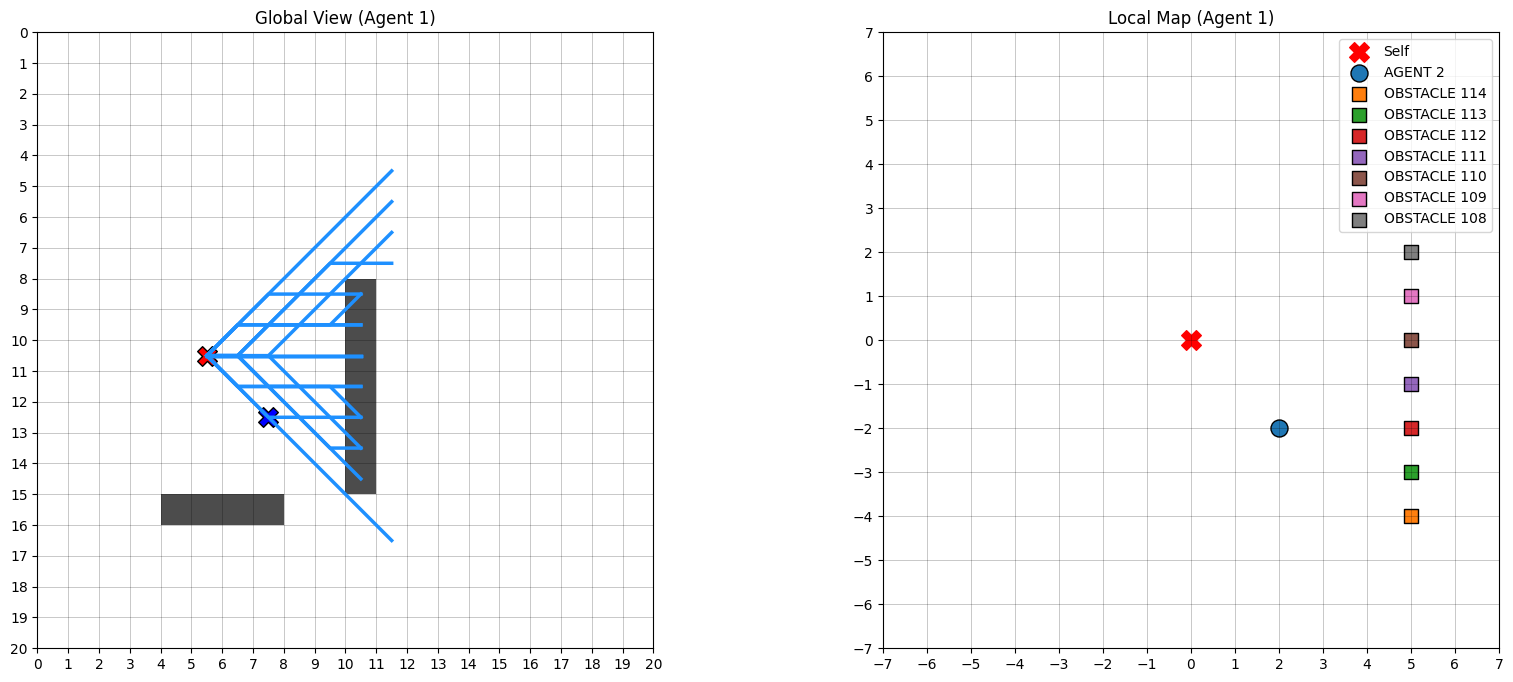

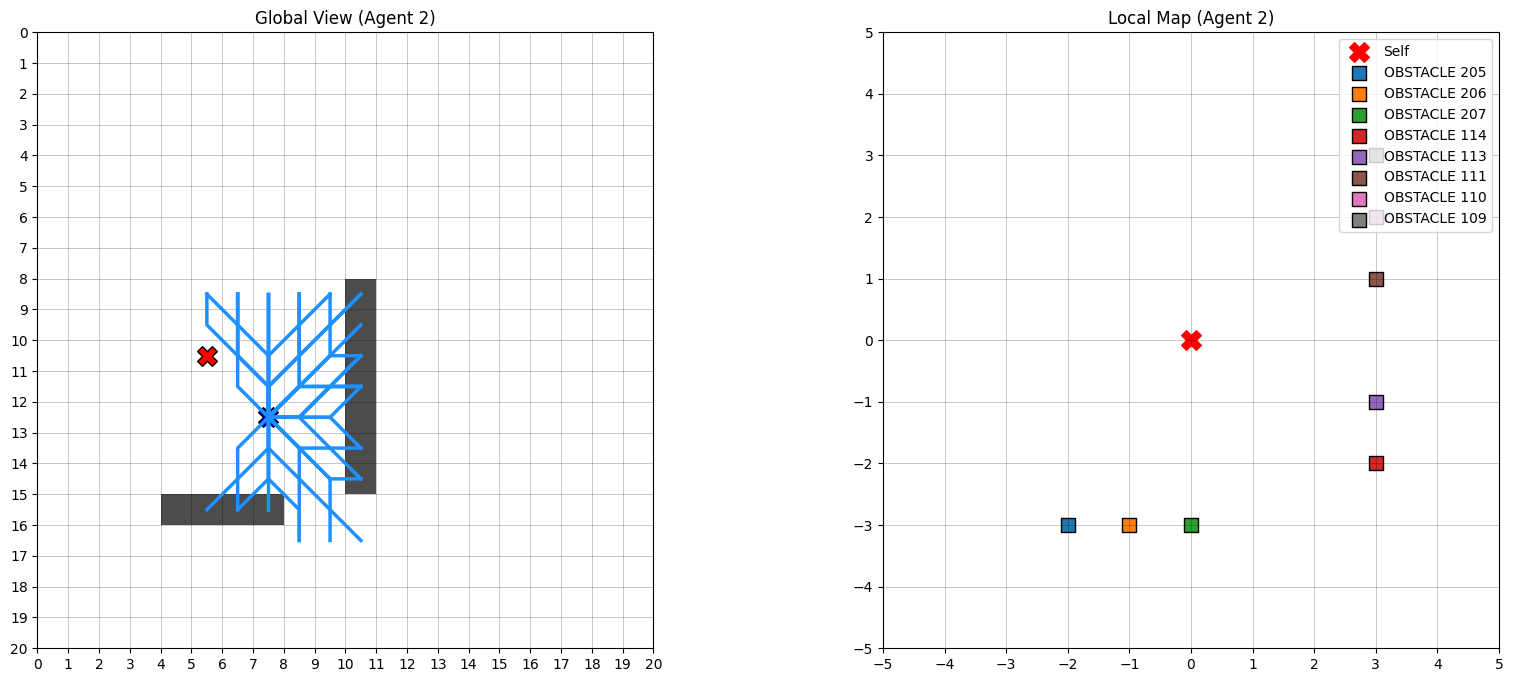

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Tuple, List

# ================= CORE CLASSES =================
class WorldObject:
    def __init__(self, oid: int, pos: Tuple[int, int], object_type: str):
        self.id = oid
        self.pos = np.array(pos, dtype=int)
        self.type = object_type

class Agent(WorldObject):
    def __init__(self, oid: int, pos: Tuple[int, int],
                 sight_radius=5, sight_ranges=None):
        super().__init__(oid, pos, "AGENT")
        self.sight_radius = sight_radius
        self.sight_ranges = sight_ranges or [((-180, 180), 15)]
        self.local_world_view: Dict[int, Tuple[str, np.ndarray]] = {}

    def update_perception(self, world: 'World'):
        """Updates the local perception of the agent."""
        self.local_world_view.clear()

        for (start, end), resolution in self.sight_ranges:
            for angle in self._angle_generator(start, end, resolution):
                self._send_raycast_bresenham(world, angle)

    def _angle_generator(self, start, end, resolution):
        """Generates angles for the sight range."""
        start = (start + 360) % 360
        end = (end + 360) % 360
        current = start

        if start > end:
            while current < 360:
                yield current
                current += resolution
            current = 0
            while current <= end:
                yield current
                current += resolution
        else:
            while current <= end:
                yield current
                current += resolution

    def _send_raycast_bresenham(self, world: 'World', angle: float) -> None:
        """Sends a raycast using the Bresenham algorithm."""
        dx = int(round(100 * np.cos(np.radians(angle))))
        dy = int(round(-100 * np.sin(np.radians(angle))))

        x0, y0 = self.pos[1], self.pos[0]
        x, y = x0, y0

        delta_x = abs(dx)
        delta_y = abs(dy)
        step_x = 1 if dx > 0 else -1
        step_y = 1 if dy > 0 else -1
        error = delta_x - delta_y

        for _ in range(self.sight_radius):
            if not (0 <= y < world.grid.shape[0] and 0 <= x < world.grid.shape[1]):
                break

            obj = world.grid[y, x]
            if obj is not None and obj.id != self.id:
                rel_pos = np.array([y - y0, x - x0])
                self.local_world_view[obj.id] = (obj.type, rel_pos)
                if obj.type == "OBSTACLE":
                    break

            e2 = 2*error
            if e2 > -delta_y:
                error -= delta_y
                x += step_x
            if e2 < delta_x:
                error += delta_x
                y += step_y

class Obstacle(WorldObject):
    def __init__(self, oid: int, pos: Tuple[int, int]):
        super().__init__(oid, pos, "OBSTACLE")

# ================= WORLD SYSTEM =================
class World:
    def __init__(self, size: Tuple[int, int]):
        self.grid = np.empty(size, dtype=object)
        self.objects: Dict[int, WorldObject] = {}

    def add_object(self, obj: WorldObject):
        if self.grid[obj.pos[0], obj.pos[1]] is not None:
            raise ValueError(f"Position {obj.pos} already occupied!")

        self.objects[obj.id] = obj
        self.grid[obj.pos[0], obj.pos[1]] = obj

    def simulate_step(self):
        for obj in self.objects.values():
            if isinstance(obj, Agent):
                obj.update_perception(self)

# ================= VISUALIZATION =================
class AgentVisualizer:
    def __init__(self, world: World):
        self.world = world

    def plot_agent_view(self, agent: Agent):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        self._plot_global_view(ax1)
        self._plot_sight_rays(ax1, agent)
        ax1.set_title(f"Global View (Agent {agent.id})")

        self._plot_local_map(ax2, agent)
        ax2.set_title(f"Local Map (Agent {agent.id})")

        plt.show()

    def _plot_global_view(self, ax):
        ax.imshow(np.zeros_like(self.world.grid, dtype=float),
                 cmap='Greys', alpha=0.2,
                 extent=[0, self.world.grid.shape[1],
                        self.world.grid.shape[0], 0])

        ax.set_xticks(np.arange(0, self.world.grid.shape[1]+1, 1))
        ax.set_yticks(np.arange(0, self.world.grid.shape[0]+1, 1))
        ax.grid(True, color='black', linestyle='-', linewidth=0.5, alpha=0.3)

        for obj in self.world.objects.values():
            if isinstance(obj, Obstacle):
                ax.add_patch(plt.Rectangle(
                    (obj.pos[1], obj.pos[0]), 1, 1,
                    fc='black', alpha=0.7
                ))

        for obj in self.world.objects.values():
            if isinstance(obj, Agent):
                ax.scatter(
                    obj.pos[1]+0.5, obj.pos[0]+0.5,
                    c='red' if obj.id == 1 else 'blue',
                    s=200, marker='X', edgecolor='black'
                )

    def _plot_sight_rays(self, ax, agent: Agent):
        for (start, end), resolution in agent.sight_ranges:
            for angle in agent._angle_generator(start, end, resolution):
                self._draw_ray(ax, agent, angle)

    def _draw_ray(self, ax, agent: Agent, angle: float):
        dx = int(round(100 * np.cos(np.radians(angle))))
        dy = int(round(-100 * np.sin(np.radians(angle))))

        x0, y0 = agent.pos[1] + 0.5, agent.pos[0] + 0.5
        x, y = agent.pos[1], agent.pos[0]

        delta_x = abs(dx)
        delta_y = abs(dy)
        step_x = 1 if dx > 0 else -1
        step_y = 1 if dy > 0 else -1
        error = delta_x - delta_y

        ray_points = [(x0, y0)]

        for _ in range(agent.sight_radius):
            # Bresenham step FIRST
            e2 = 2 * error
            if e2 > -delta_y:
                error -= delta_y
                x += step_x
            if e2 < delta_x:
                error += delta_x
                y += step_y

            # Check break conditions BEFORE adding the point
            if not (0 <= y < self.world.grid.shape[0] and
                    0 <= x < self.world.grid.shape[1]):
                break

            obj = self.world.grid[y, x]
            if isinstance(obj, Obstacle) and obj.id != agent.id:
                # Add point BEFORE breaking
                x_plot = x + 0.5
                y_plot = y + 0.5
                ray_points.append((x_plot, y_plot))
                break  # Leave loop

            # Add point after step
            x_plot = x + 0.5
            y_plot = y + 0.5
            ray_points.append((x_plot, y_plot))

        # Draw line
        x_values, y_values = zip(*ray_points)
        ax.plot(x_values, y_values,
                color='dodgerblue', lw=2.5, alpha=1.0)

    def _plot_local_map(self, ax, agent: Agent):
        ax.scatter(0, 0, c='red', s=200, marker='X', label="Self")

        for obj_id, (object_type, rel_pos) in agent.local_world_view.items():
            ax.scatter(
                rel_pos[1],
                -rel_pos[0],
                label=f"{object_type} {obj_id}",
                s=100 if object_type == "OBSTACLE" else 150,
                marker='s' if object_type == "OBSTACLE" else 'o',
                edgecolor='black'
            )
        ax.set_xticks(np.arange(-agent.sight_radius-1, agent.sight_radius+2, 1))
        ax.set_yticks(np.arange(-agent.sight_radius-1, agent.sight_radius+2, 1))
        ax.grid(True, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
        ax.set_xlim(-agent.sight_radius-1, agent.sight_radius+1)
        ax.set_ylim(-agent.sight_radius-1, agent.sight_radius+1)
        ax.set_aspect('equal')
        ax.legend(loc='upper right')

# ================= TEST SETUP =================
if __name__ == "__main__":
    world = World((20, 20))

    wolf = Agent(1, (10, 5),
                sight_radius=6,
                sight_ranges=[((-45, 45), 5)])

    cow = Agent(2, (12, 7),
               sight_radius=4,
               sight_ranges=[((-120, -10), 10), ((10, 120), 5)])

    world.add_object(wolf)
    world.add_object(cow)

    # Create obstacle wall
    for y in range(8, 15):
        h = Obstacle(100+y, (y, 10))
        world.add_object(h)
    for x in range(4, 8):
        h = Obstacle(200+x, (15, x))
        world.add_object(h)

    world.simulate_step()

    visualizer = AgentVisualizer(world)
    visualizer.plot_agent_view(wolf)
    visualizer.plot_agent_view(cow)

## Zielfindung

### Frontier Detection

## Routenplanung und Kollisionsvermeidung